In [1]:
from pythainlp.ulmfit import *
from pythainlp.util import normalize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import emoji
import re
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump
import seaborn as sns
from collections import Counter

In [2]:
df = pd.read_csv('./dataandpythai_V2.csv', sep=',')
df = df.drop_duplicates(subset=['Sentiment', 'SentimentText'], keep=False)
df = df.reset_index(drop=True)
s = {0:'Negative', 1:'Neutral'}
df['Sentiment'] = df['Sentiment'].map(s)

In [172]:
df.sample(5)

,Sentiment,SentimentText
31374,Neutral,แอดมินขอส่งเรื่องให้หัวหน้างานตรวจสอบการทำงานข...
8651,Negative,ทำไมติดต่อผมไม่ได้
24850,Negative,เนื่องจากวันเกิดเซฮุนมายเมน🌈 แจก ลิปHolika Hol...
9033,Negative,ทำไมพัสดุถึงขึ้นติดต่อผู้รับไม่ได้คะ ในเมื่อไม...
23923,Neutral,ขอของขวัญเป็นผลิตภัณฑ์ลอรีเอะใช้ฟรี 1 ปีค่ะ🎁🎁 🤣


<AxesSubplot:>

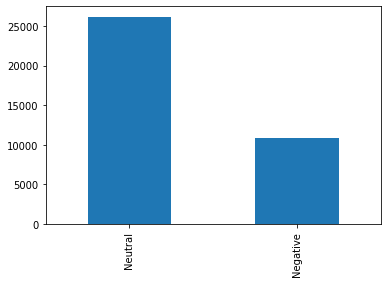

In [3]:
df['Sentiment'].value_counts().plot.bar()

In [4]:
def text_process(text):
    words = re.sub(r'[^ก-๙]', '', text)
    words = normalize(words)
    words = process_thai(words,
                             pre_rules=[replace_rep_after, fix_html, rm_useless_spaces],
                             post_rules=[ungroup_emoji,
                             replace_wrep_post_nonum,
                             remove_space]
                          )
    words = ' '.join(word for word in words)
    return words
df['SentimentText'] = df['SentimentText'].apply(text_process)
nan_value = float("NaN")
df.replace("", nan_value, inplace=True)
df.dropna(subset = ["SentimentText"], inplace=True)

In [5]:
df.sample(5)

,Sentiment,SentimentText
17682,Neutral,คุ้ม นี่ คือ บุ ฟเฟ่ เบียร์ ช้าง ที่ เพิ่ม อีก...
14320,Neutral,ใหม่ เคาะ วัน เปิดตัว ใน ไทย แล้ว มีนาคม นี้
82,Negative,ปกติ วัน เดียว ถึง จะแจ้ง ใน แอ พ ว่า ถึง สาขา...
25057,Neutral,มา กก หิว เบย นิ
27930,Neutral,เด่ ว ให้ คำตอบ


In [6]:
X = df[['SentimentText']]
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [7]:
start = time()
count_vec = CountVectorizer(tokenizer=process_thai, analyzer='word', min_df=2, max_df=.5, ngram_range=(1,3))
count_vec.fit_transform(X_train['SentimentText'])
train_bow = count_vec.transform(X_train['SentimentText'])
tf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True, norm='l2', sublinear_tf=True)
tf_transformer.fit(train_bow)
Xtrain_tf = tf_transformer.transform(train_bow)
ros = RandomOverSampler(random_state=101)
rus = RandomUnderSampler(random_state=101)
Xtrain_tf, y_train = ros.fit_resample(Xtrain_tf, y_train)
Xtrain_tf, y_train = rus.fit_resample(Xtrain_tf, y_train)

lr = LogisticRegression(C=5 , solver='liblinear', max_iter=1000)
lr.fit(Xtrain_tf, y_train)
print(time() - start)

37.79277539253235


In [8]:
nb = MultinomialNB(alpha=0.01)
nb.fit(Xtrain_tf, y_train)

MultinomialNB(alpha=0.01)

In [9]:
Xtest_tf = count_vec.transform(X_test['SentimentText'])
test_bow = tf_transformer.transform(Xtest_tf)
nbtest_predictions = nb.predict(test_bow)
precision = precision_score(nbtest_predictions, y_test, average='weighted')
score = f1_score(nbtest_predictions, y_test, average='weighted')
recall = recall_score(nbtest_predictions, y_test, average='weighted')
print(classification_report(nbtest_predictions, y_test))
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('Accuracy: %.4f' % score )

              precision    recall  f1-score   support

    Negative       0.76      0.61      0.68      2674
     Neutral       0.80      0.89      0.84      4540

    accuracy                           0.79      7214
   macro avg       0.78      0.75      0.76      7214
weighted avg       0.78      0.79      0.78      7214

Precision: 0.7841
Recall: 0.7864
Accuracy: 0.7805


In [10]:
lrtest_predictions = lr.predict(test_bow)
precision = precision_score(lrtest_predictions, y_test, average='weighted')
score = f1_score(lrtest_predictions, y_test, average='weighted')
# score = accuracy_score(test_predictions, y_test)
recall = recall_score(lrtest_predictions, y_test, average='weighted')
print(classification_report(lrtest_predictions, y_test))
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('Accuracy: %.4f' % score)

              precision    recall  f1-score   support

    Negative       0.71      0.70      0.70      2196
     Neutral       0.87      0.88      0.87      5018

    accuracy                           0.82      7214
   macro avg       0.79      0.79      0.79      7214
weighted avg       0.82      0.82      0.82      7214

Precision: 0.8211
Recall: 0.8222
Accuracy: 0.8216


In [16]:
sentence = 'ก็โอเค ระบบดีมากทำงานกันยังไงนิแย่มาก'
tokens = text_process(sentence)
print(tokens)
bow = count_vec.transform(pd.Series([tokens]))
bow_tf_idf = tf_transformer.transform(bow)
predict = lr.predict(bow_tf_idf)
predict

ก็ โอเค ระบบ ดีมาก ทำงาน กัน ยังไง นิ แย่มาก


array(['Negative'], dtype=object)

0.8221513723315775


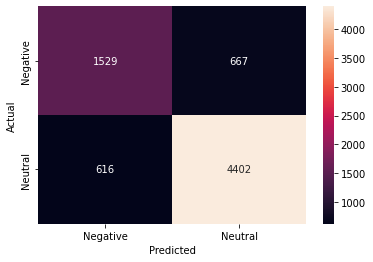

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix(lrtest_predictions,y_test)
print(lr.score(test_bow, y_test))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [181]:
from joblib import dump
dump(count_vec, "./vectors.joblib")
dump(tf_transformer, "./lr_tf_vectors.joblib")
dump(lr, "./logistic.joblib")

['./logistic.joblib']

In [182]:
x_test = X_test['SentimentText'].values
predicted_result = pd.DataFrame(x_test, columns=['SentimentText'])
predicted_result['Predictions'] = test_predictions
predicted_result.to_csv('prediction.csv', encoding='utf-8-sig')

In [35]:
dict_sentiment = {'Negative': 0, 'Neutral': 1}
y_pred = [dict_sentiment[d] for d in lrtest_predictions]

In [37]:
from sklearn.metrics import plot_roc_curve, RocCurveDisplay
disp = plot_roc_curve(lr, y_pred, y_test)
# plot_roc_curve(nb, test_bow, y_test, ax=disp.ax_)

C:\Users\Thiti\Desktop\proposal\sentiment-chatbot\train\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[1 1 1 ... 1 1 1].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.